In [22]:
!pip install pandas openpyxl matplotlib seaborn



[notice] A new release of pip is available: 24.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Step 1: Explore Excel Structure and Validate Data Sections

## Before extracting any data, preview the first few rows and columns of each sheet.
## This ensures we understand the sheet’s structure, where section headers are, and if our parsing logic will work for all sheets.


In [30]:
for sheet in sheet_names:
    raw_df = pd.read_excel(xls, sheet_name=sheet, header=None)
    print(f"First 20 rows for {sheet}:")
    print(raw_df.iloc[:20,0])




First 20 rows for Valid 1:
0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
12   NaN
13   NaN
14   NaN
15   NaN
16   NaN
17   NaN
18   NaN
19   NaN
Name: 0, dtype: float64
First 20 rows for Valid 2:
0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
12   NaN
13   NaN
14   NaN
15   NaN
16   NaN
17   NaN
18   NaN
19   NaN
Name: 0, dtype: float64
First 20 rows for Valid 3:
0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
12   NaN
13   NaN
14   NaN
15   NaN
16   NaN
17   NaN
18   NaN
19   NaN
Name: 0, dtype: float64
First 20 rows for Invalid 1:
0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
12   NaN
13   NaN
14   NaN
15   NaN
16   NaN
17   NaN
18   NaN
19   NaN
Name: 0, dtype: float64
First 20 rows for Invalid 2:
0    NaN
1    NaN
2    NaN
3    NaN
4    NaN


In [32]:
raw_df = pd.read_excel(xls, sheet_name='Valid 1', header=None)
print(raw_df.head(25))



    0                    1             2           3           4   \
0  NaN                  NaN           NaN         NaN         NaN   
1  NaN                  NaN           NaN         NaN         NaN   
2  NaN           Total Data           NaN         NaN         NaN   
3  NaN                 Date  unique_idfas  unique_ips  unique_uas   
4  NaN     11 Sep to 15 Sep       1191603     1189884          28   
5  NaN                  NaN           NaN         NaN         NaN   
6  NaN                  NaN           NaN         NaN         NaN   
7  NaN           Daily Data           NaN         NaN         NaN   
8  NaN                 Date  unique_idfas  unique_ips  unique_uas   
9  NaN  2025-09-11 00:00:00         93345       93340          22   
10 NaN  2025-09-12 00:00:00        515646      515307          25   
11 NaN  2025-09-13 00:00:00        406993      406729          25   
12 NaN  2025-09-14 00:00:00        400917      400668          26   
13 NaN  2025-09-15 00:00:00       

# Step 2: Extracting Hourly Data From Each App Sheet

## Here we define a function that locates the "Hourly Data" header, grabs the columns, and builds a per-app DataFrame. This skips unrelated data and ensures our analysis focuses on the right granularity.The loop creates a cleaned dictionary of hourly traffic for all apps for quick, consistent analysis.


In [42]:
import pandas as pd

xls = pd.ExcelFile('Data Analytics Assignment.xlsx')
sheet_names = xls.sheet_names

def get_hourly_df(sheet):
    raw_df = pd.read_excel(xls, sheet_name=sheet, header=None)
    idx = raw_df[raw_df.iloc[:,1] == "Hourly Data"].index[0]
    columns = raw_df.iloc[idx+1, 1:12].tolist()
    section = raw_df.iloc[idx+2:, 1:12]
    section.columns = columns
    section.columns = [str(c).strip() for c in section.columns]  # Clean column names!
    section = section[section['Date'].notna()]
    for col in section.columns:
        if col != 'Date':
            section[col] = pd.to_numeric(section[col], errors='coerce')
    section['Date'] = pd.to_datetime(section['Date'], errors='coerce')
    return section

hourly_dfs = {sheet: get_hourly_df(sheet) for sheet in sheet_names}

# Step 3: IVT (Invalid Traffic) Time Series Analysis

## We plot IVT over time for each app. Sharp spikes indicate moments when traffic was marked as invalid.
## This gives an at-a-glance view showing which apps had potential fraud events and which apps were consistently clean.

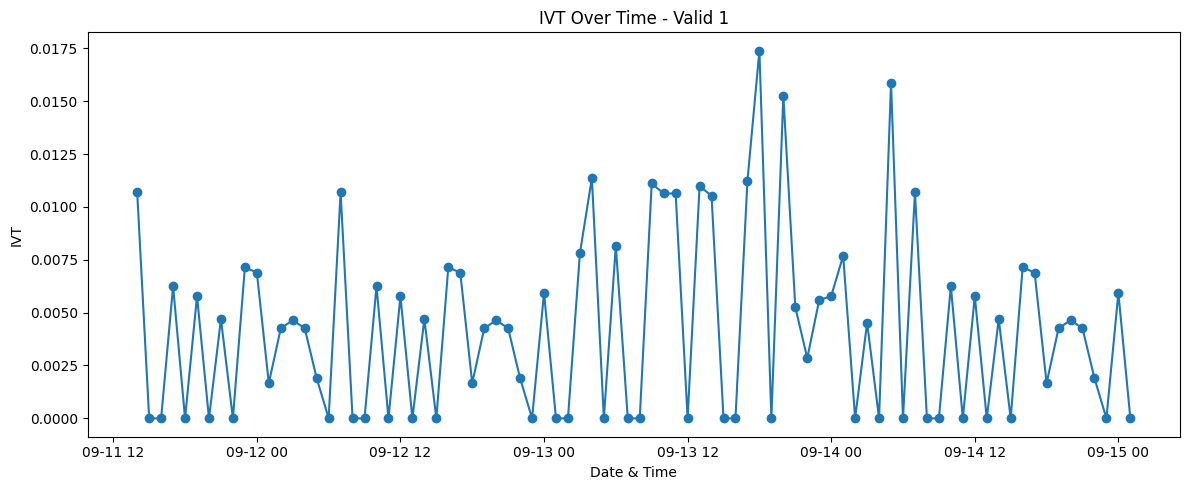

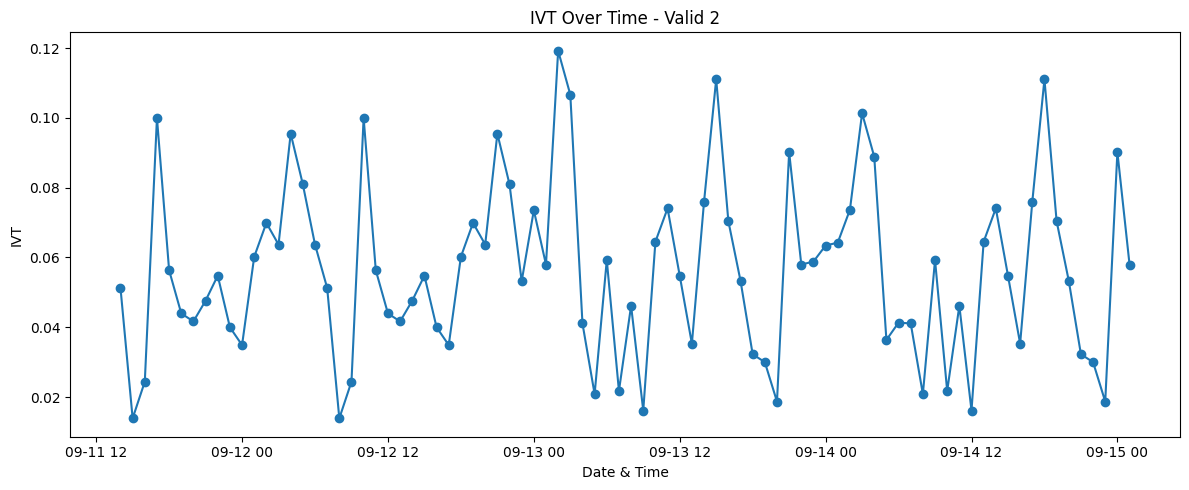

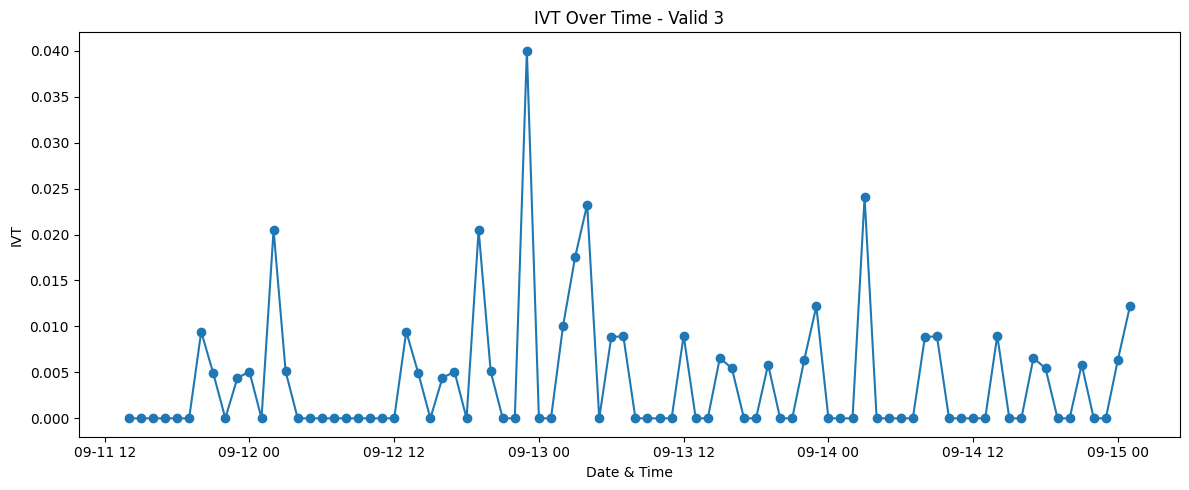

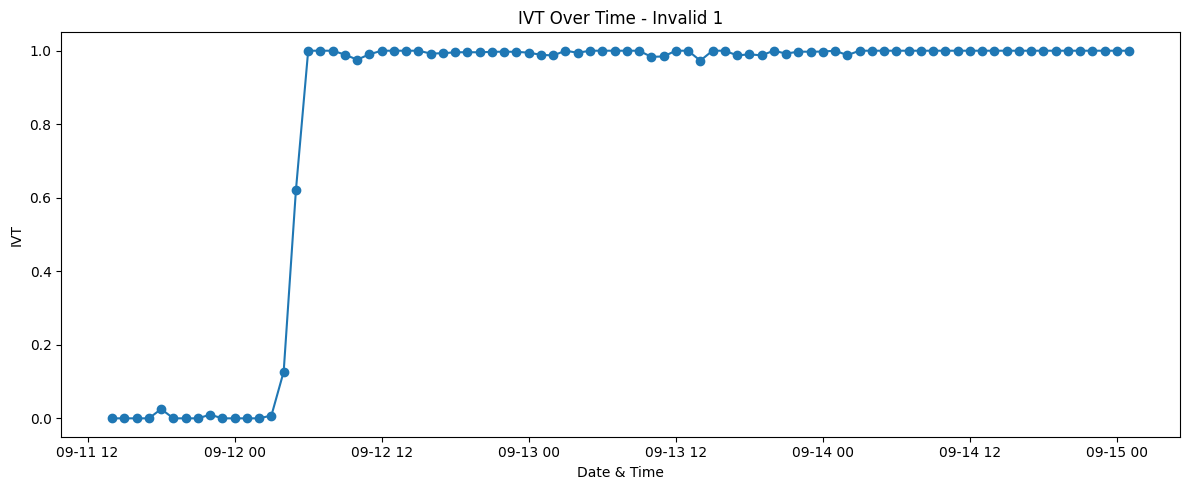

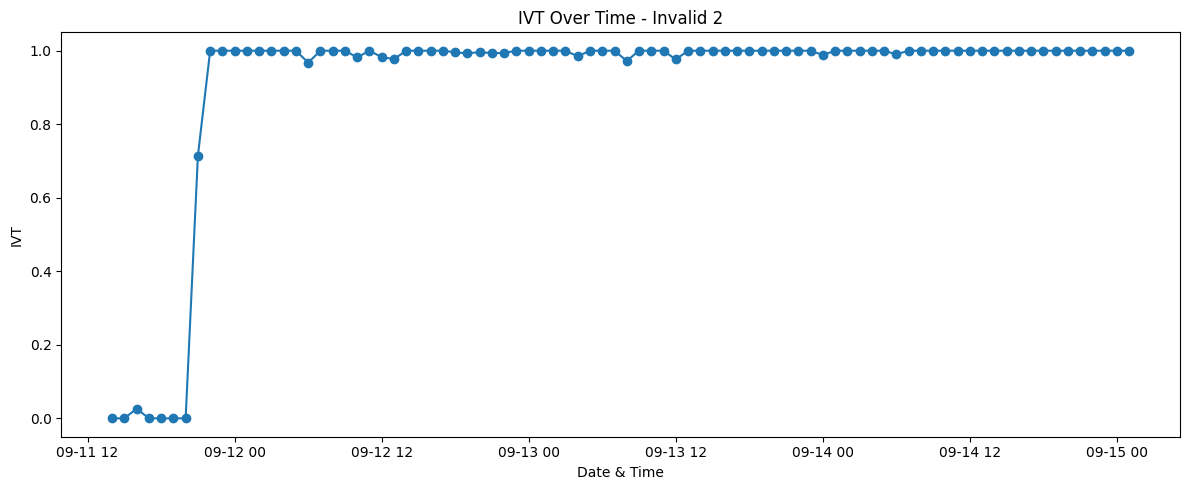

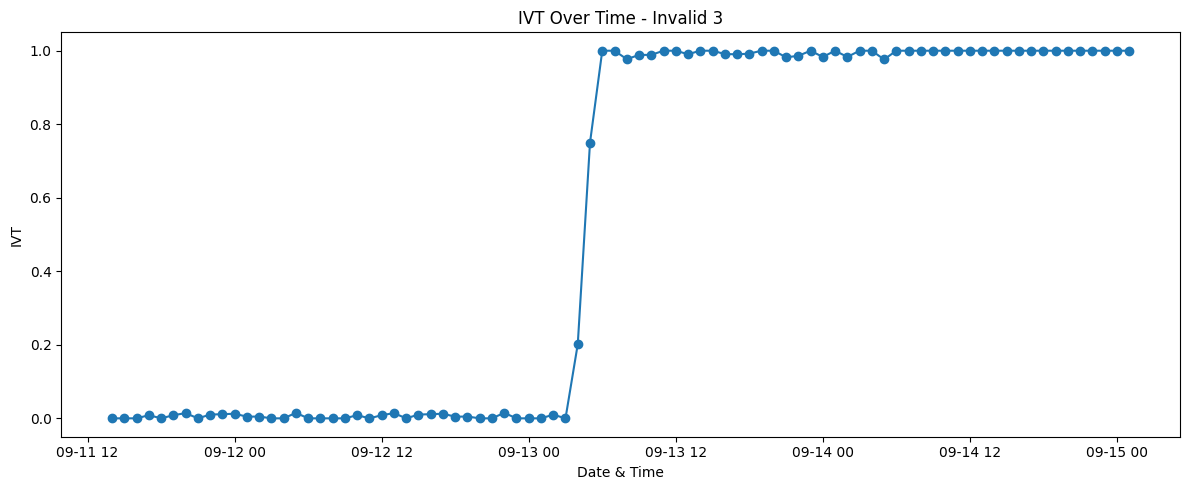

In [44]:
import matplotlib.pyplot as plt

for app, df in hourly_dfs.items():
    plt.figure(figsize=(12, 5))
    plt.plot(df['Date'], df['IVT'], marker='o')
    plt.title(f'IVT Over Time - {app}')
    plt.xlabel('Date & Time')
    plt.ylabel('IVT')
    plt.tight_layout()
    plt.show()


# Step 4: Analyzing Key Feature Values When IVT Spikes

## For each app, we extract and display the values of major features the moment IVT first jumps.
## Seeing these values helps us understand what changed in the traffic right when IVT became significant—important for identifying triggers or unusual patterns.


In [63]:
for app, df in hourly_dfs.items():
    df.columns = [str(c).strip() for c in df.columns]
    ivt_spikes = df[df['IVT'] > 0]
    if not ivt_spikes.empty:
        first_ivt = ivt_spikes.iloc[0]
        print(f"\n{app} - First IVT Spike at {first_ivt['Date']}:")
        print(first_ivt[['Date', 'IVT', 'idfa_ua_ratio', 'idfa_ip_ratio', 'requests_per_idfa', 'unique_idfas', 'unique_uas', 'unique_ips']])
    else:
        print(f"\n{app} - Never marked IVT.")



Valid 1 - First IVT Spike at 2025-09-11 14:00:00:
Date                 2025-09-11 14:00:00
IVT                             0.010695
idfa_ua_ratio                 207.941176
idfa_ip_ratio                        1.0
requests_per_idfa               1.011881
unique_idfas                        3535
unique_uas                            17
unique_ips                          3535
Name: 18, dtype: object

Valid 2 - First IVT Spike at 2025-09-11 14:00:00:
Date                 2025-09-11 14:00:00
IVT                             0.051282
idfa_ua_ratio                  28.495238
idfa_ip_ratio                        1.0
requests_per_idfa               1.039104
unique_idfas                        2992
unique_uas                           105
unique_ips                          2992
Name: 18, dtype: object

Valid 3 - First IVT Spike at 2025-09-11 20:00:00:
Date                 2025-09-11 20:00:00
IVT                             0.009434
idfa_ua_ratio                      921.5
idfa_ip_ratio       

# Step 5: Feature Correlations With IVT

## Each app’s main traffic metrics are compared against IVT using statistical correlation.
## This shows which features are most predictive of IVT marking—a strong positive correlation suggests possible triggers for traffic fraud detection.


In [67]:
for app, df in hourly_dfs.items():
    df.columns = [str(c).strip() for c in df.columns]
    print(f"\nCorrelation matrix for {app}:")
    print(df.corr()['IVT'].sort_values(ascending=False))



Correlation matrix for Valid 1:
IVT                     1.000000
Date                    0.054204
unique_uas              0.011936
unique_ips             -0.026437
unique_idfas           -0.026438
total_requests         -0.026626
idfa_ua_ratio          -0.033904
requests_per_idfa      -0.059435
idfa_ip_ratio          -0.081361
impressions                  NaN
impressions_per_idfa         NaN
Name: IVT, dtype: float64

Correlation matrix for Valid 2:
IVT                     1.000000
idfa_ua_ratio           0.151850
unique_ips              0.119602
unique_idfas            0.119587
total_requests          0.113743
idfa_ip_ratio           0.034884
Date                    0.018946
unique_uas             -0.004147
requests_per_idfa      -0.085011
impressions                  NaN
impressions_per_idfa         NaN
Name: IVT, dtype: float64

Correlation matrix for Valid 3:
IVT                     1.000000
Date                    0.015365
idfa_ip_ratio          -0.119525
unique_ips             -

# Step 6: Visualizing Feature Trends and Outliers

## The use color-coded scatterplots to visualize key features versus IVT.
## This makes it easy to spot if any feature values jump or drift at the same moment IVT flips. 
## Such outliers are prime candidates for further monitoring or operational fraud rules.


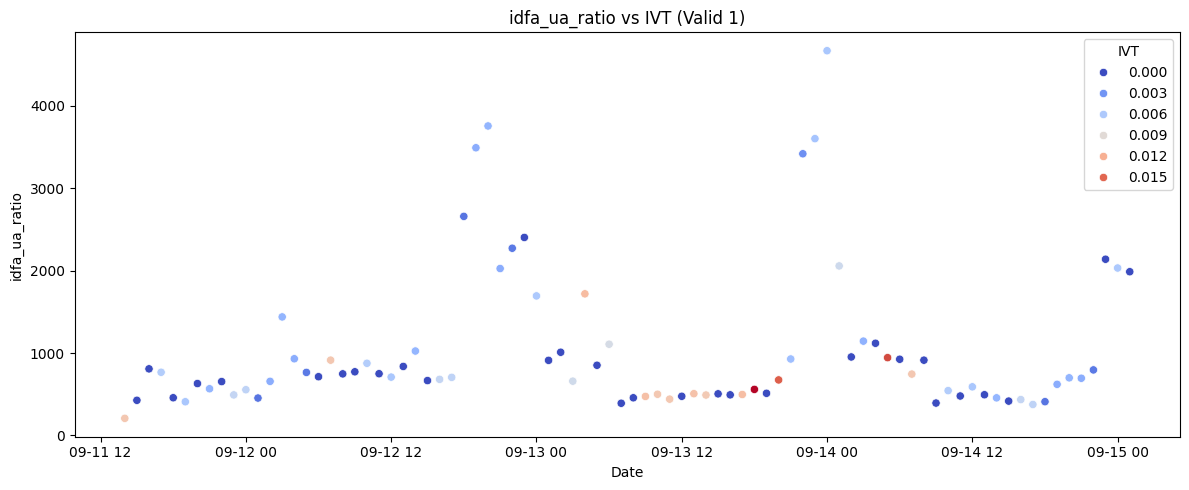

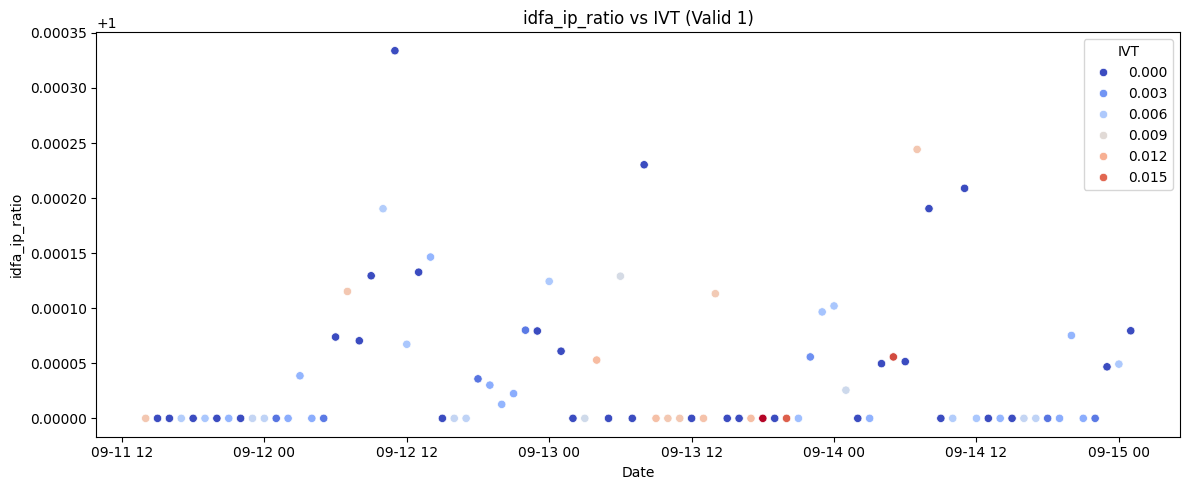

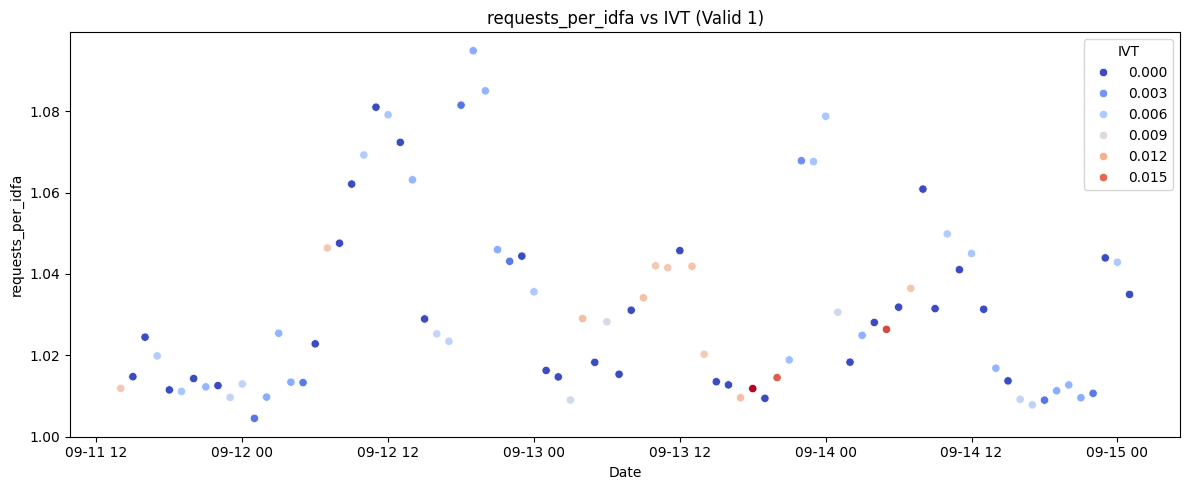

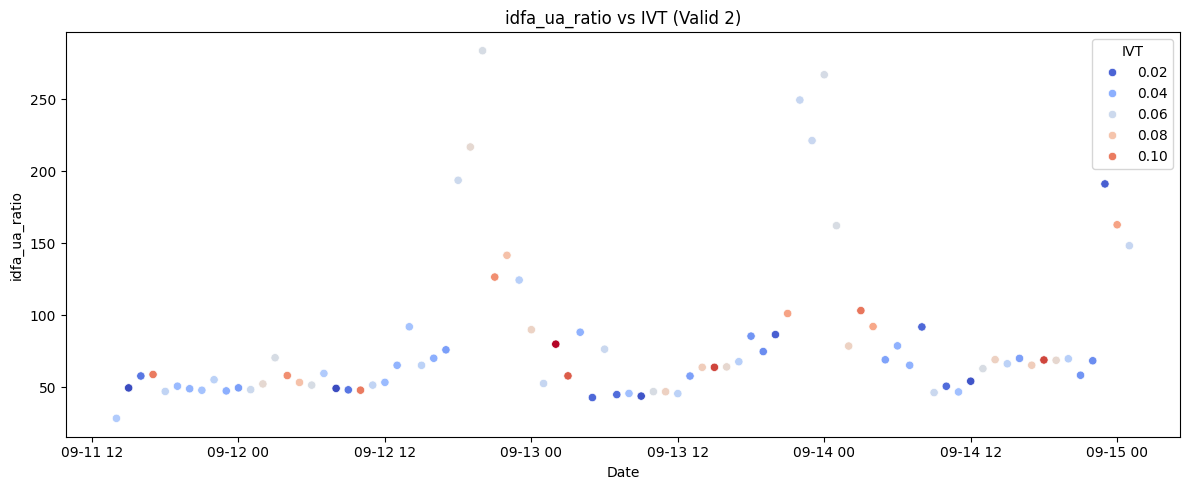

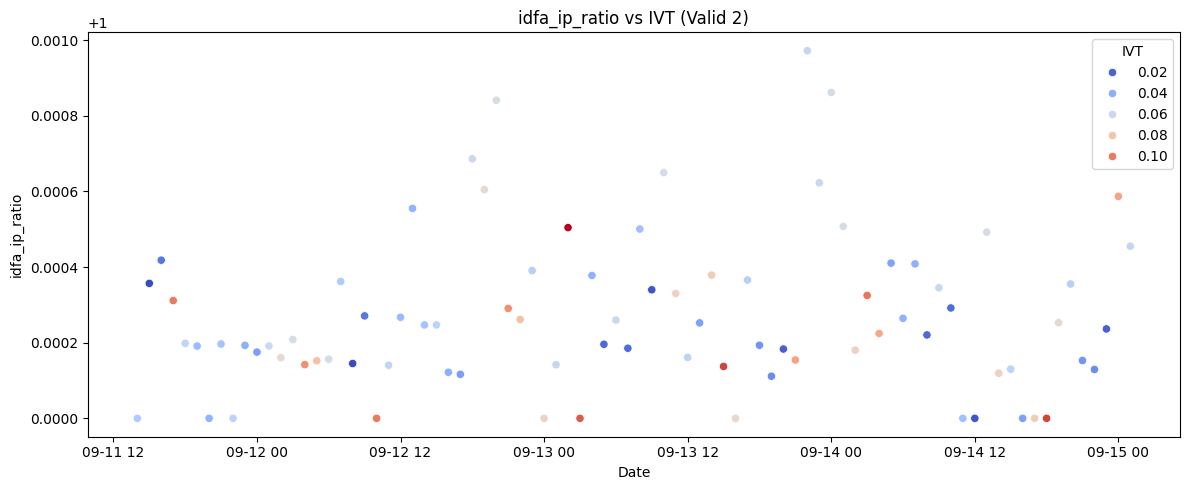

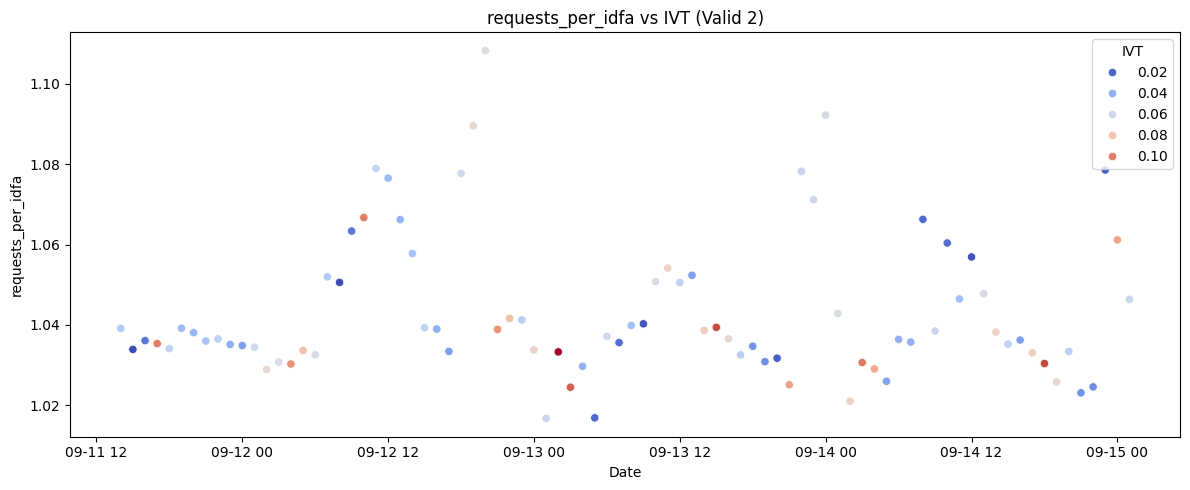

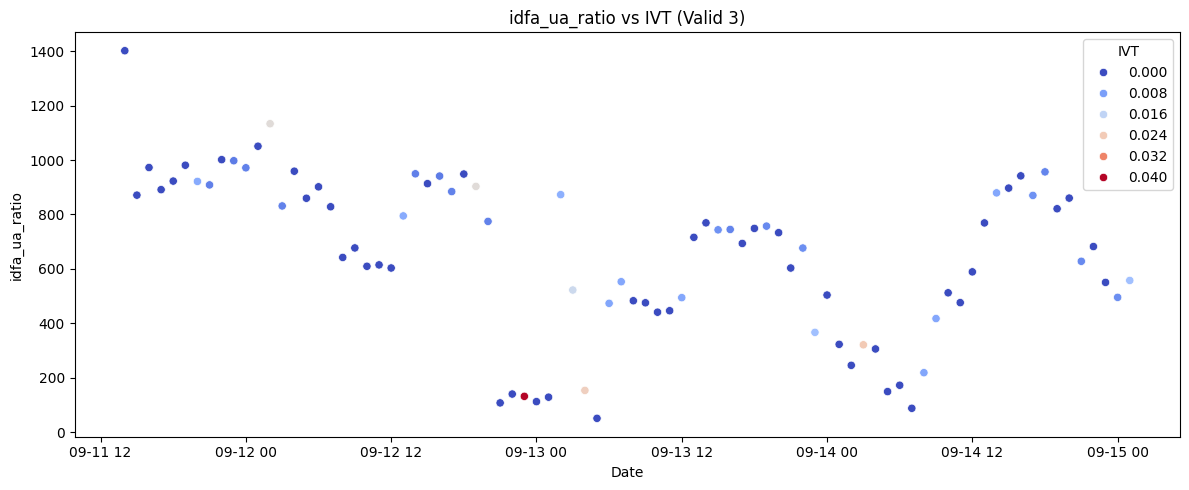

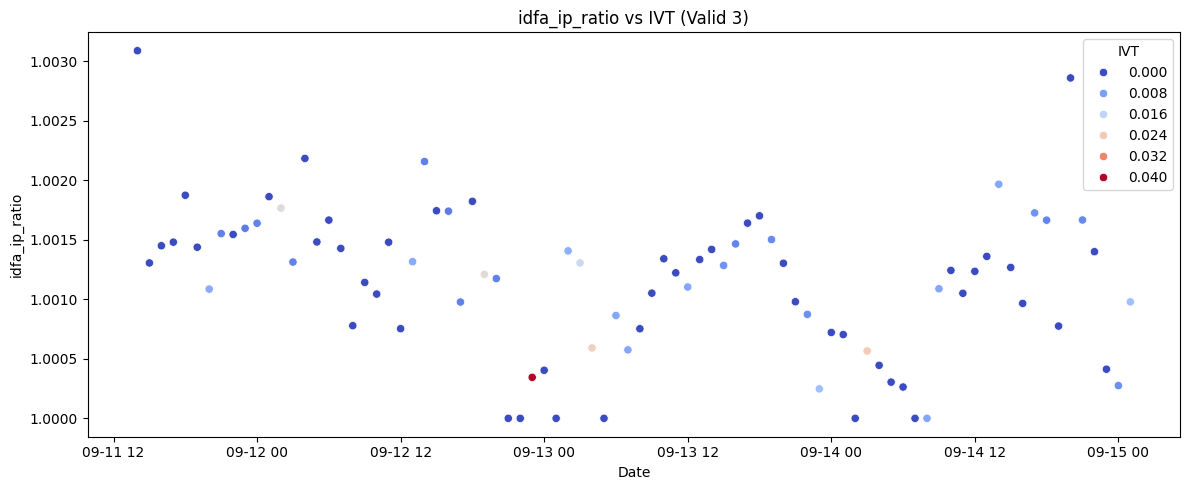

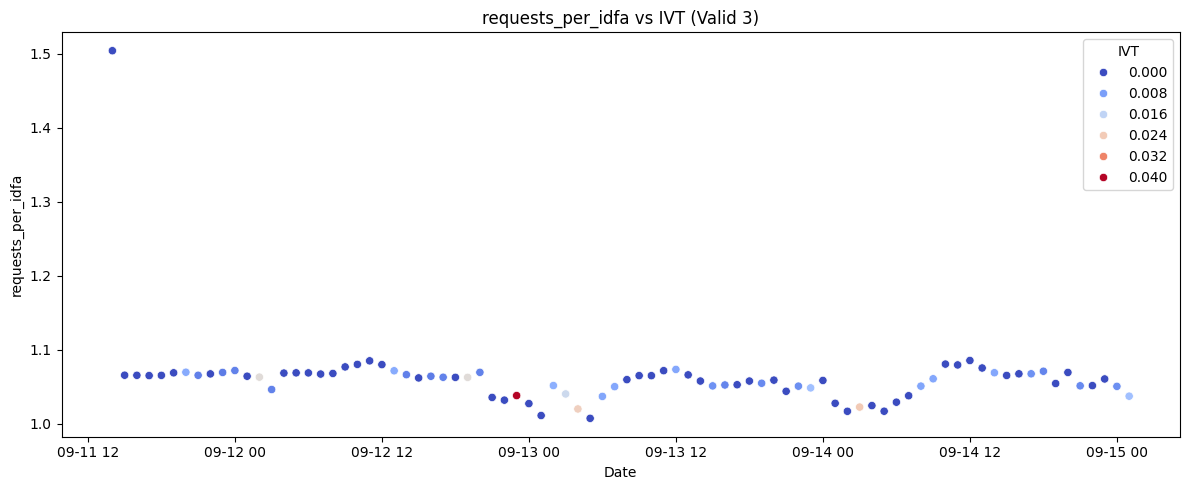

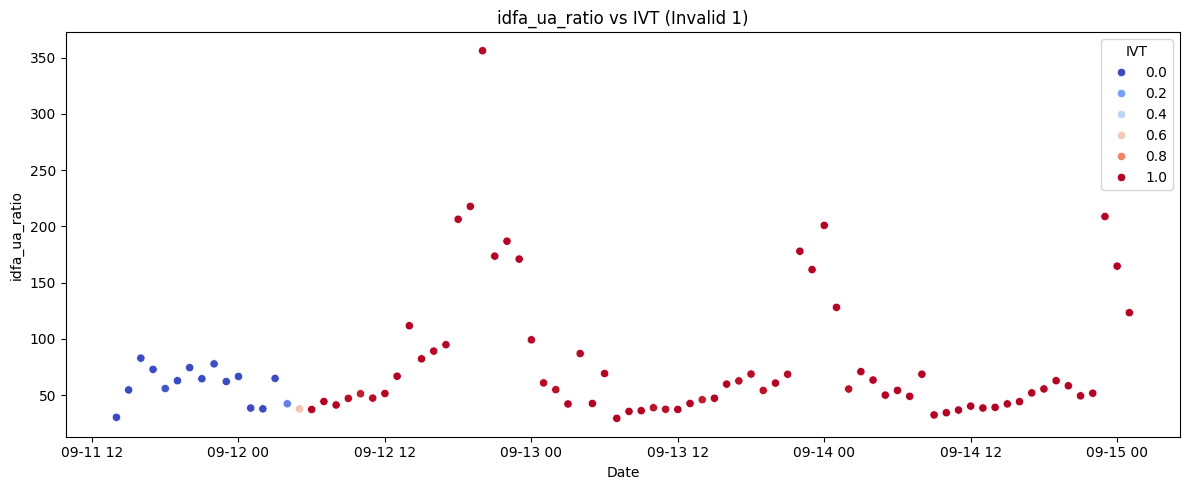

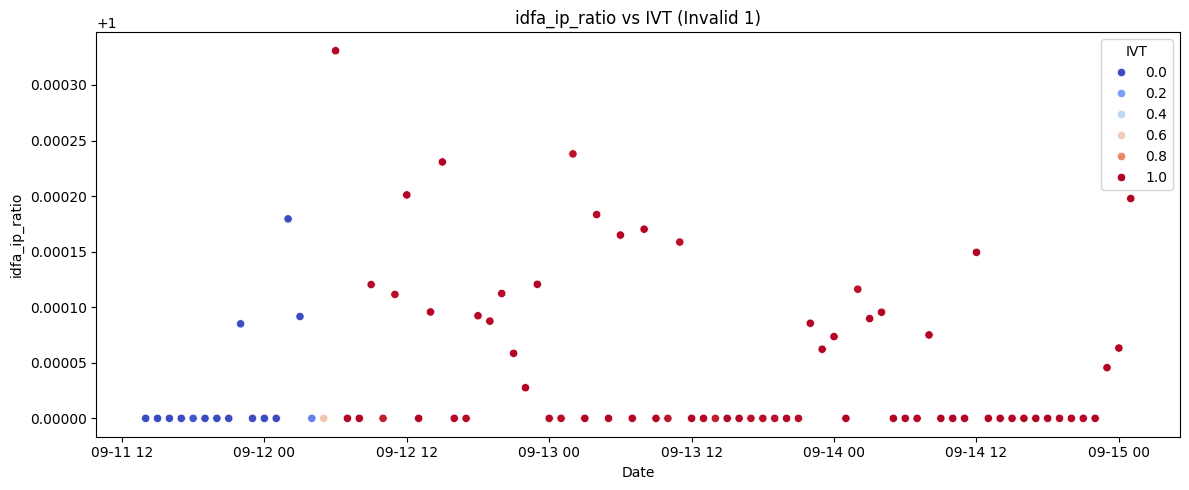

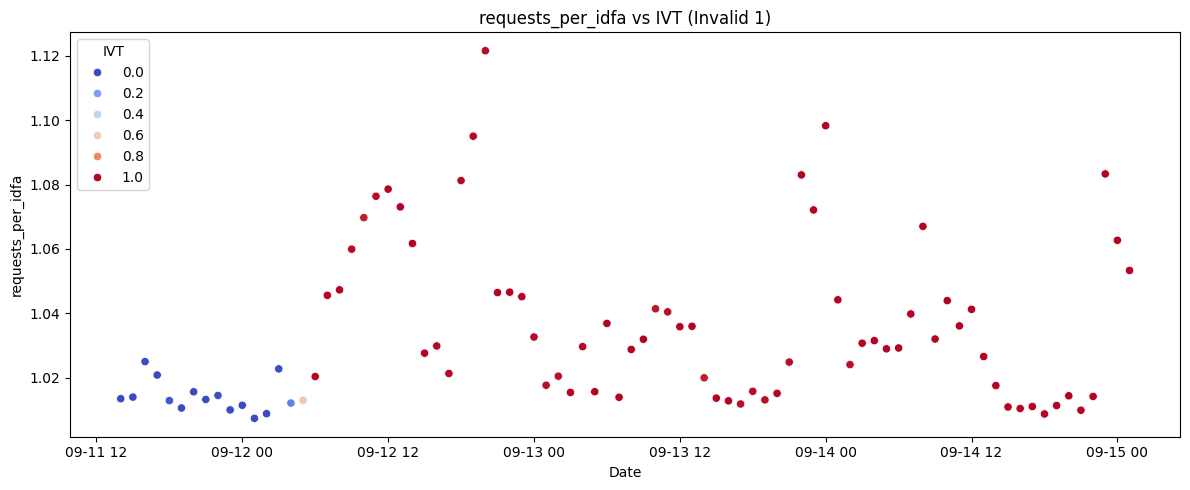

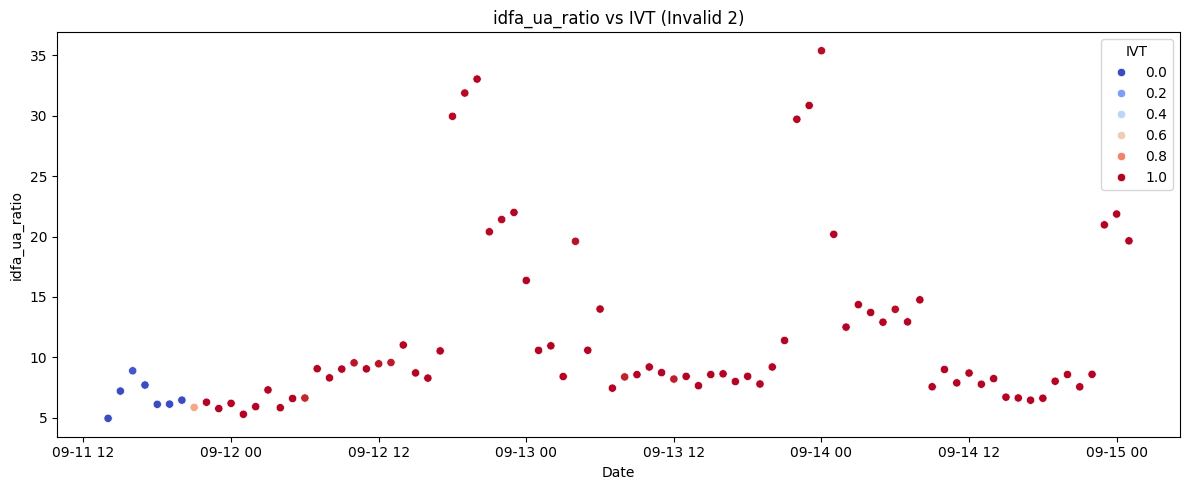

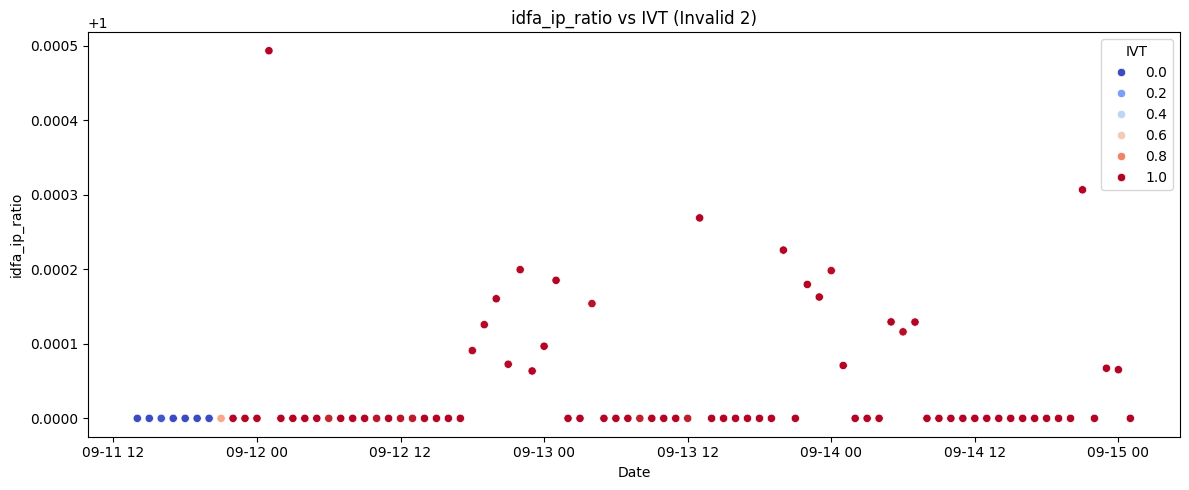

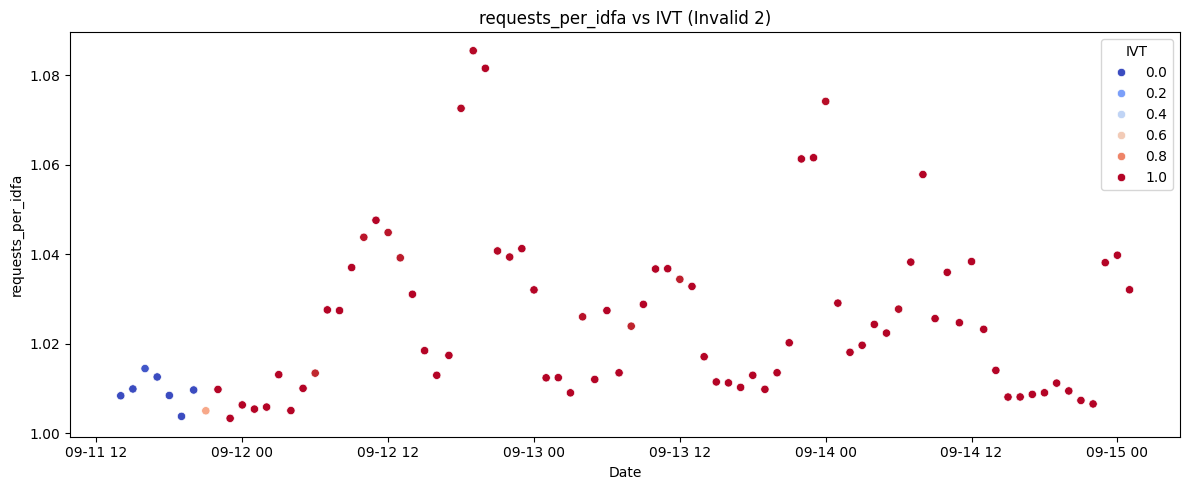

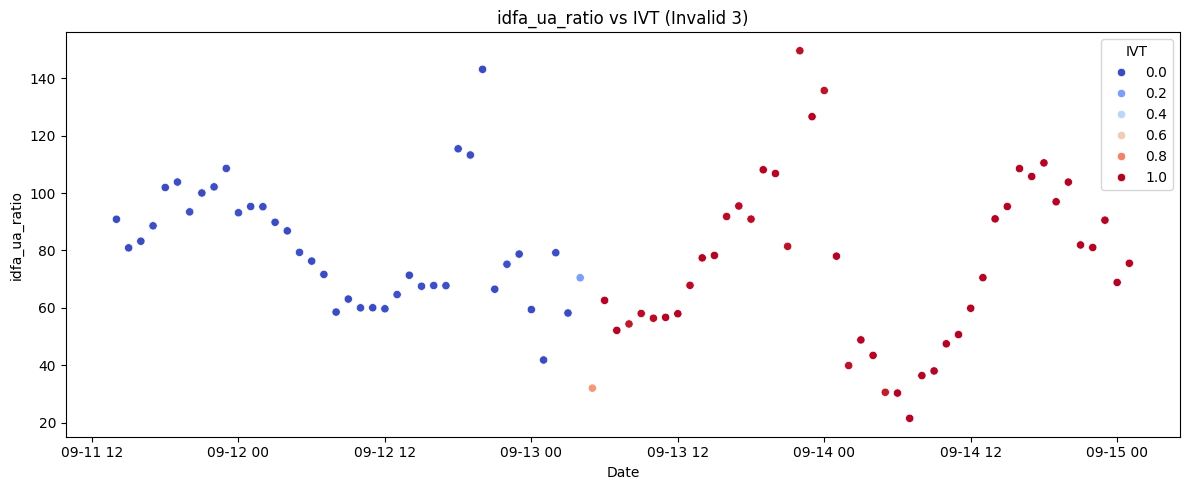

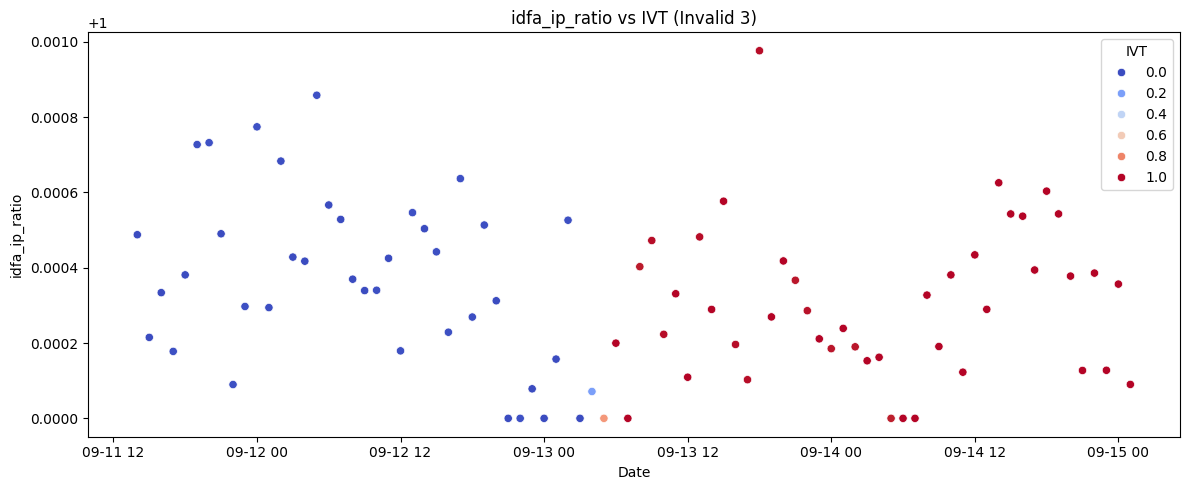

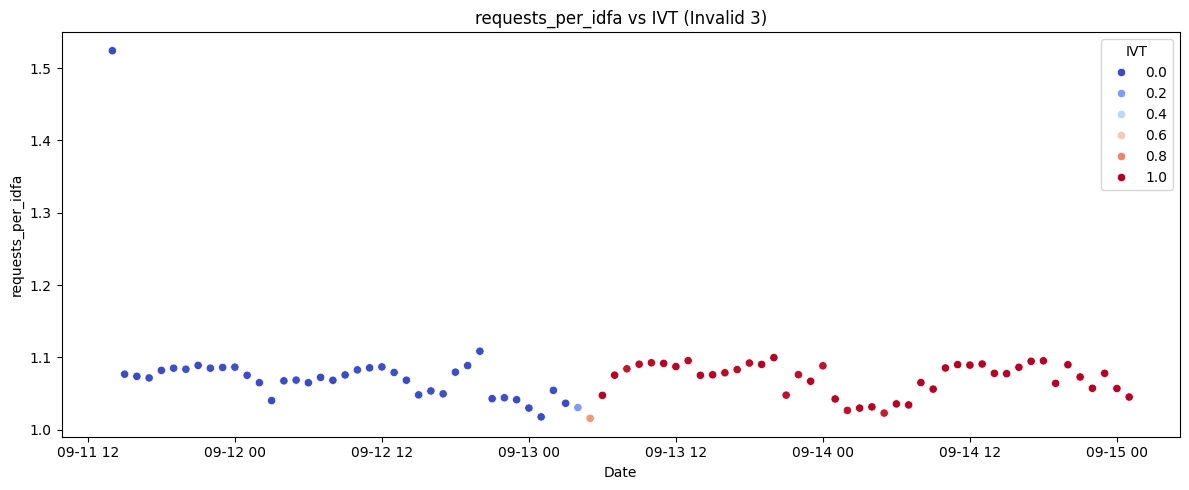

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns


metrics = ['idfa_ua_ratio', 'idfa_ip_ratio', 'requests_per_idfa']

for app, df in hourly_dfs.items():
    df.columns = [str(c).strip() for c in df.columns]
    for metric in metrics:
        plt.figure(figsize=(12,5))
        # Color by IVT: big change in color = trigger point
        sns.scatterplot(x='Date', y=metric, hue='IVT', palette='coolwarm', data=df)
        plt.title(f"{metric} vs IVT ({app})")
        plt.xlabel('Date')
        plt.ylabel(metric)
        plt.tight_layout()
        plt.show()
